In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from catboost import CatBoost
import os
import glob

In [207]:
pathes = glob.glob('D:\Downloads\ECG_Prediction\*.csv')

data_all = [];
for i in pathes[0:10]:
    data =  pd.read_csv(i)[0:20000]
    data_all.append(data)
    
# df = pd.concat(data_all, axis=0, ignore_index=True)

In [208]:
data_all[2]

,'sample #','V5','V2'
0,0,984,1025
1,1,984,1025
2,2,984,1025
3,3,984,1025
4,4,984,1025
...,...,...,...
19995,19995,945,984
19996,19996,944,980
19997,19997,942,980
19998,19998,939,979


In [209]:
data_settings = data_all[2]
columns = data_settings.columns
signal_setting = data_settings[columns[1]]
signal_setting = signal_setting[0:20000]

(0.0, 17500.0)

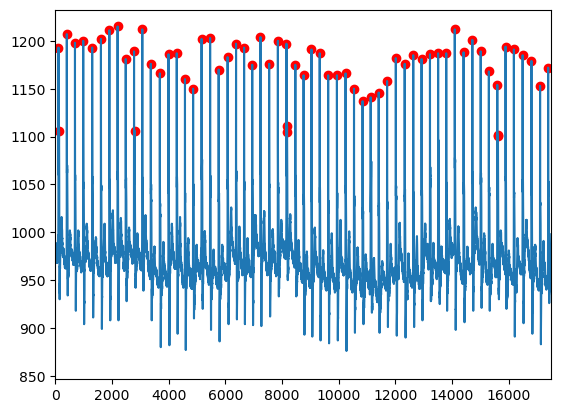

In [211]:
peaks = find_peaks(signal_setting, height=1100)
plt.plot(signal_setting)
plt.scatter(peaks[0], signal_setting[peaks[0]], color='red')
plt.xlim([0, 17500])

In [252]:
window_size = 500
stride = 6
y_lim = 0.1
x_lim = 10

In [253]:
def find_peaks_my(signal, peaks):
    dataset = []
    middles = []
    peak_count = 0
    for i in range(0, len(signal)-window_size, stride):
        norm_coef = np.max(np.abs(signal[i:i+window_size]))
        piece = signal[i:i+window_size] / norm_coef
        piece = piece - np.mean(piece)
        is_peak = 0
        middle = int((i + i + window_size) / 2)
        for peak in peaks[0]:
            if peak >= middle - x_lim and \
                peak < middle + x_lim and \
                (signal[peak] - signal[middle]) / norm_coef < y_lim:
                is_peak = 1
                peak_count += 1
                middles.append(middle)
                break
        piece = np.append(piece, is_peak)
    
        dataset.append(piece)
    return dataset, peak_count, middles

In [254]:
dataset, p_count, middles = find_peaks_my(signal = signal_setting, peaks=peaks)
df = pd.DataFrame(dataset)

(0.0, 2000.0)

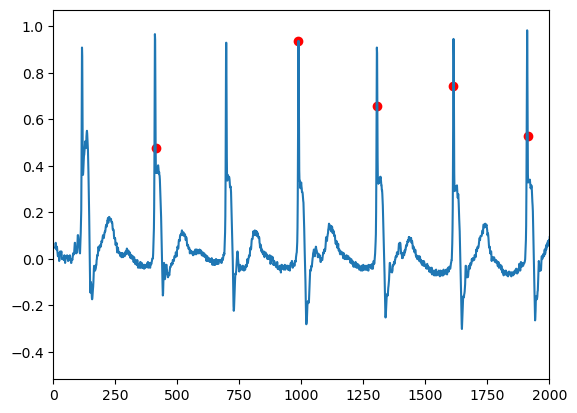

In [255]:
norm_sig = signal_setting - np.mean(signal_setting)
norm_sig = norm_sig / np.max(norm_sig)
plt.plot(norm_sig)
plt.scatter(middles, norm_sig[middles], color='red')
plt.xlim([0, 2000])

In [256]:
result_signal = []
for df in data_all:
    result_signal.extend(df[df.columns[1]])
peaks_all = find_peaks(result_signal, height=1095)

In [257]:
dataset, p_count, middles = find_peaks_my(signal=result_signal, peaks=peaks_all)
df = pd.DataFrame(dataset)

(40000.0, 50000.0)

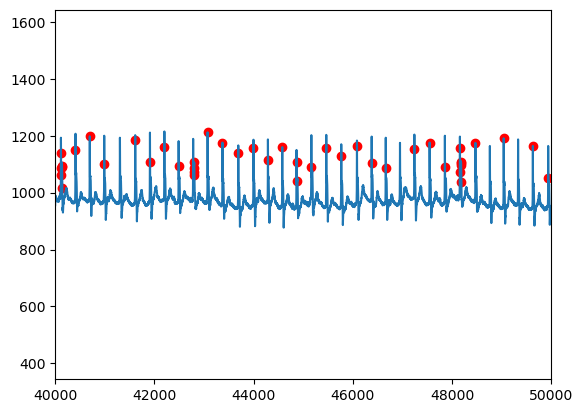

In [263]:
df_to_plot = pd.DataFrame(result_signal)
plt.plot(result_signal)
plt.scatter(middles[:p_count], df_to_plot[0][middles[:p_count]], color='red')
plt.xlim([40000, 50000])

In [259]:
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[: , :window_size], df[window_size], test_size = 0.15)

booster = CatBoost(params={'iterations':100, 'loss_function':'Logloss'})

booster.fit(X_train, Y_train, eval_set=(X_test, Y_test))
booster.set_feature_names([str(i) for i in range(window_size)])

test_preds = booster.predict(X_test, prediction_type="Class")
train_preds = booster.predict(X_train, prediction_type="Class")

Learning rate set to 0.19695
0:	learn: 0.3415148	test: 0.3418055	best: 0.3418055 (0)	total: 75.4ms	remaining: 7.46s
1:	learn: 0.1615728	test: 0.1624174	best: 0.1624174 (1)	total: 145ms	remaining: 7.12s
2:	learn: 0.0910686	test: 0.0910044	best: 0.0910044 (2)	total: 220ms	remaining: 7.12s
3:	learn: 0.0612450	test: 0.0616589	best: 0.0616589 (3)	total: 288ms	remaining: 6.92s
4:	learn: 0.0463265	test: 0.0469627	best: 0.0469627 (4)	total: 353ms	remaining: 6.71s
5:	learn: 0.0399415	test: 0.0408743	best: 0.0408743 (5)	total: 418ms	remaining: 6.55s
6:	learn: 0.0350322	test: 0.0364810	best: 0.0364810 (6)	total: 487ms	remaining: 6.47s
7:	learn: 0.0314228	test: 0.0333857	best: 0.0333857 (7)	total: 551ms	remaining: 6.33s
8:	learn: 0.0296360	test: 0.0319677	best: 0.0319677 (8)	total: 615ms	remaining: 6.21s
9:	learn: 0.0281319	test: 0.0308025	best: 0.0308025 (9)	total: 692ms	remaining: 6.23s
10:	learn: 0.0264315	test: 0.0291515	best: 0.0291515 (10)	total: 768ms	remaining: 6.22s
11:	learn: 0.0253509	t

96:	learn: 0.0069109	test: 0.0186732	best: 0.0186732 (96)	total: 6.89s	remaining: 213ms
97:	learn: 0.0068437	test: 0.0187059	best: 0.0186732 (96)	total: 6.96s	remaining: 142ms
98:	learn: 0.0066532	test: 0.0186689	best: 0.0186689 (98)	total: 7.03s	remaining: 71ms
99:	learn: 0.0066116	test: 0.0186460	best: 0.0186460 (99)	total: 7.1s	remaining: 0us

bestTest = 0.01864596851
bestIteration = 99



In [264]:
from catboost.utils import eval_metric
print("\nTest  Accuracy : %f"%eval_metric(Y_test.values, test_preds, "Accuracy")[0])
print("Train Accuracy : %f"%eval_metric(Y_train.values, train_preds, "Accuracy")[0])
print(len(Y_test.values))


Test  Accuracy : 0.993384
Train Accuracy : 0.998726
4988


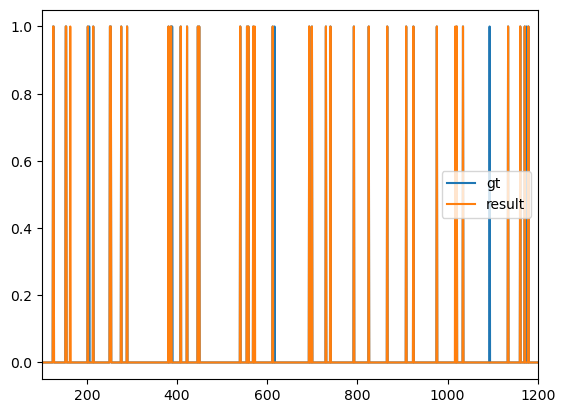

In [265]:
plt.plot(Y_test.values, label='gt')
plt.plot(test_preds, label='result')
plt.xlim([100, 1200])
plt.legend()

(100.0, 1200.0)

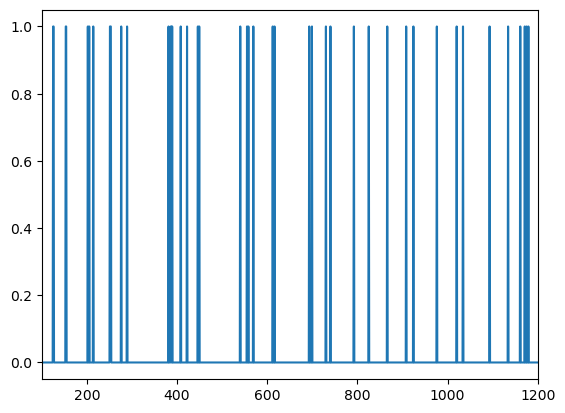

In [266]:
plt.plot(Y_test.values, label='gt')
plt.xlim([100, 1200])

In [267]:
data_check = pd.read_csv('D:\\Downloads\\ECG_Prediction\\122.csv')
signal_check = data_check['\'MLII\''].values
signal_check = signal_check[0:50000]

In [268]:
dataset_check = []
middles_check = []
for i in range(0, len(signal_check)-window_size, stride):
    piece = signal_check[i:i+window_size] / np.max(np.abs(signal_check[i:i+window_size]))
    piece = piece - np.mean(piece)
    middle = (i + i + window_size) / 2
    middles_check.append(middle)
    dataset_check.append(piece)

In [269]:
df_check = pd.DataFrame(dataset_check)
test_preds = booster.predict(df_check, prediction_type="Class")

(0.0, 1200.0)

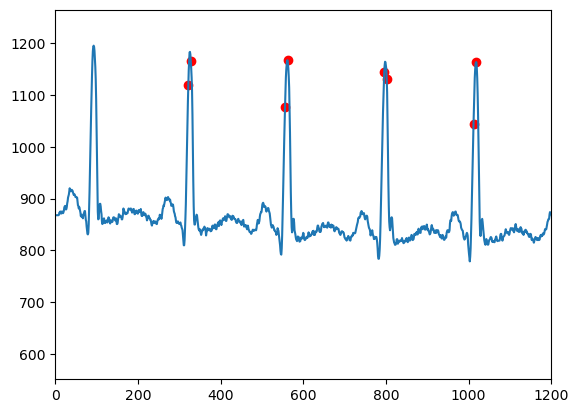

In [270]:
peaks_check = np.where(test_preds>0)[0]
middles_check = np.asarray(middles_check, dtype=int)
plt.plot(signal_check)
plt.scatter(middles_check[peaks_check], signal_check[middles_check[peaks_check]], color='red')
plt.xlim([0, 1200])
